In [6]:
%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd
from protest_impact.util import project_root

path = project_root / "protest_impact/data/protests/german_protest_registrations/csv"

dfs = dict()
for file in path.glob("*"):
    print(file)
    if file.is_dir():
        continue
    if file.suffix == ".csv":
        df = pd.read_csv(file)
        # df = pd.read_csv(file, sep=";")
    elif file.suffix in (".xls", ".xlsx"):
        dfname = pd.ExcelFile(file)
        df = pd.DataFrame()
        for name in dfname.sheet_names:
            dfnew = pd.read_excel(file, sheet_name=name)
            dfnew["sheet_name"] = name
            df = pd.concat([df, dfnew])
    elif file.suffix == ".ods":
        df = pd.read_excel(file, engine="odf")
    city = file.stem
    for col in df.columns:
        if "Unnamed" in col:
            df = df.drop(columns=col)
    dfs[city] = df
    df.to_csv(
        project_root
        / "protest_impact/data/protests/german_protest_registrations/csv"
        / f"{city}.csv",
        index=False,
    )

/Users/david/Repositories/protest-impact/protest_impact/data/protests/german_protest_registrations/csv/wuppertal.csv
/Users/david/Repositories/protest-impact/protest_impact/data/protests/german_protest_registrations/csv/bremen.csv
/Users/david/Repositories/protest-impact/protest_impact/data/protests/german_protest_registrations/csv/münchen.csv
/Users/david/Repositories/protest-impact/protest_impact/data/protests/german_protest_registrations/csv/dresden.csv
/Users/david/Repositories/protest-impact/protest_impact/data/protests/german_protest_registrations/csv/magdeburg.csv
/Users/david/Repositories/protest-impact/protest_impact/data/protests/german_protest_registrations/csv/mainz.csv
/Users/david/Repositories/protest-impact/protest_impact/data/protests/german_protest_registrations/csv/köln.csv
/Users/david/Repositories/protest-impact/protest_impact/data/protests/german_protest_registrations/csv/karlsruhe.csv
/Users/david/Repositories/protest-impact/protest_impact/data/protests/german_pro

In [8]:
del dfs["freiburg"]

In [9]:
# for Munich: red color means cancelled event

# from openpyxl import load_workbook

# wb = load_workbook(project_root / "datasets" / "official-data" / "raw" / "münchen.xlsx", data_only = True)

# df = pd.DataFrame()
# for sheet in wb.worksheets:
#     df_ = pd.read_excel(project_root / "datasets" / "official-data" / "raw" / "münchen.xlsx", sheet_name = sheet.title, engine="openpyxl")
#     not_cancelled = [cell.font.color is None for cell in sheet["A:A"][1:]]
#     df__ = df_[not_cancelled]
#     print(sheet.title, df_.shape, df__.shape)
#     df = pd.concat([df, df__], axis=0)
# for col in df.columns:
#     if "Unnamed" in col:
#         df = df.drop(columns=col)
# print(df.shape)
# df.to_csv(project_root / "datasets" / "official-data" / "csv" / "münchen.csv", index=False)

In [10]:
for city, df in dfs.items():
    assert "Datum" in df.columns, f"{city} does not have date column ({df.columns})"
    assert "Thema" in df.columns, f"{city} does not have topic column ({df.columns})"
    if not "Teilnehmer" in df.columns:
        print(f"{city} does not have size column")

bremen does not have size column
erfurt does not have size column


In [11]:
import re


def split_dates(df):
    # some rows contain multiple dates
    # so we split them and duplicate the row
    def split(datum):
        if isinstance(datum, str) and not datum.endswith("00:00:00"):
            return re.split(r"\s*[,;+]+\s*|\s+und\s+|\s+u\.?\s+|\s+\/\s+|\s+", datum)
        else:
            return [datum]

    return df.assign(Datum=df["Datum"].apply(split)).explode("Datum").reset_index()

In [12]:
import datetime


def fix_df(df_):
    df = df_.copy()
    df = split_dates(df)
    i = 0
    for idx in df.index:
        if isinstance(df.Datum[idx], (pd.Timestamp, datetime.datetime, datetime.date)):
            continue
        try:
            if re.match(r"^\d{1,2}.\d{1,2}\.?$", df.Datum[idx]):
                if "sheet_name" in df.columns and int(df.sheet_name[idx]) >= 2000:
                    df.Datum[idx] = df.Datum[idx] + str(df.sheet_name[idx])
            pd.to_datetime(df.Datum[idx], dayfirst=True)
        except Exception as e:
            print(type(df.Datum[idx]))
            print(df.Datum[idx])
            print(df.loc[idx])
            print(e)
            i += 1
    print(i)
    # df.Datum = pd.to_datetime(df.Datum, dayfirst=True)

In [13]:
fix_df(dfs["erfurt"])

0


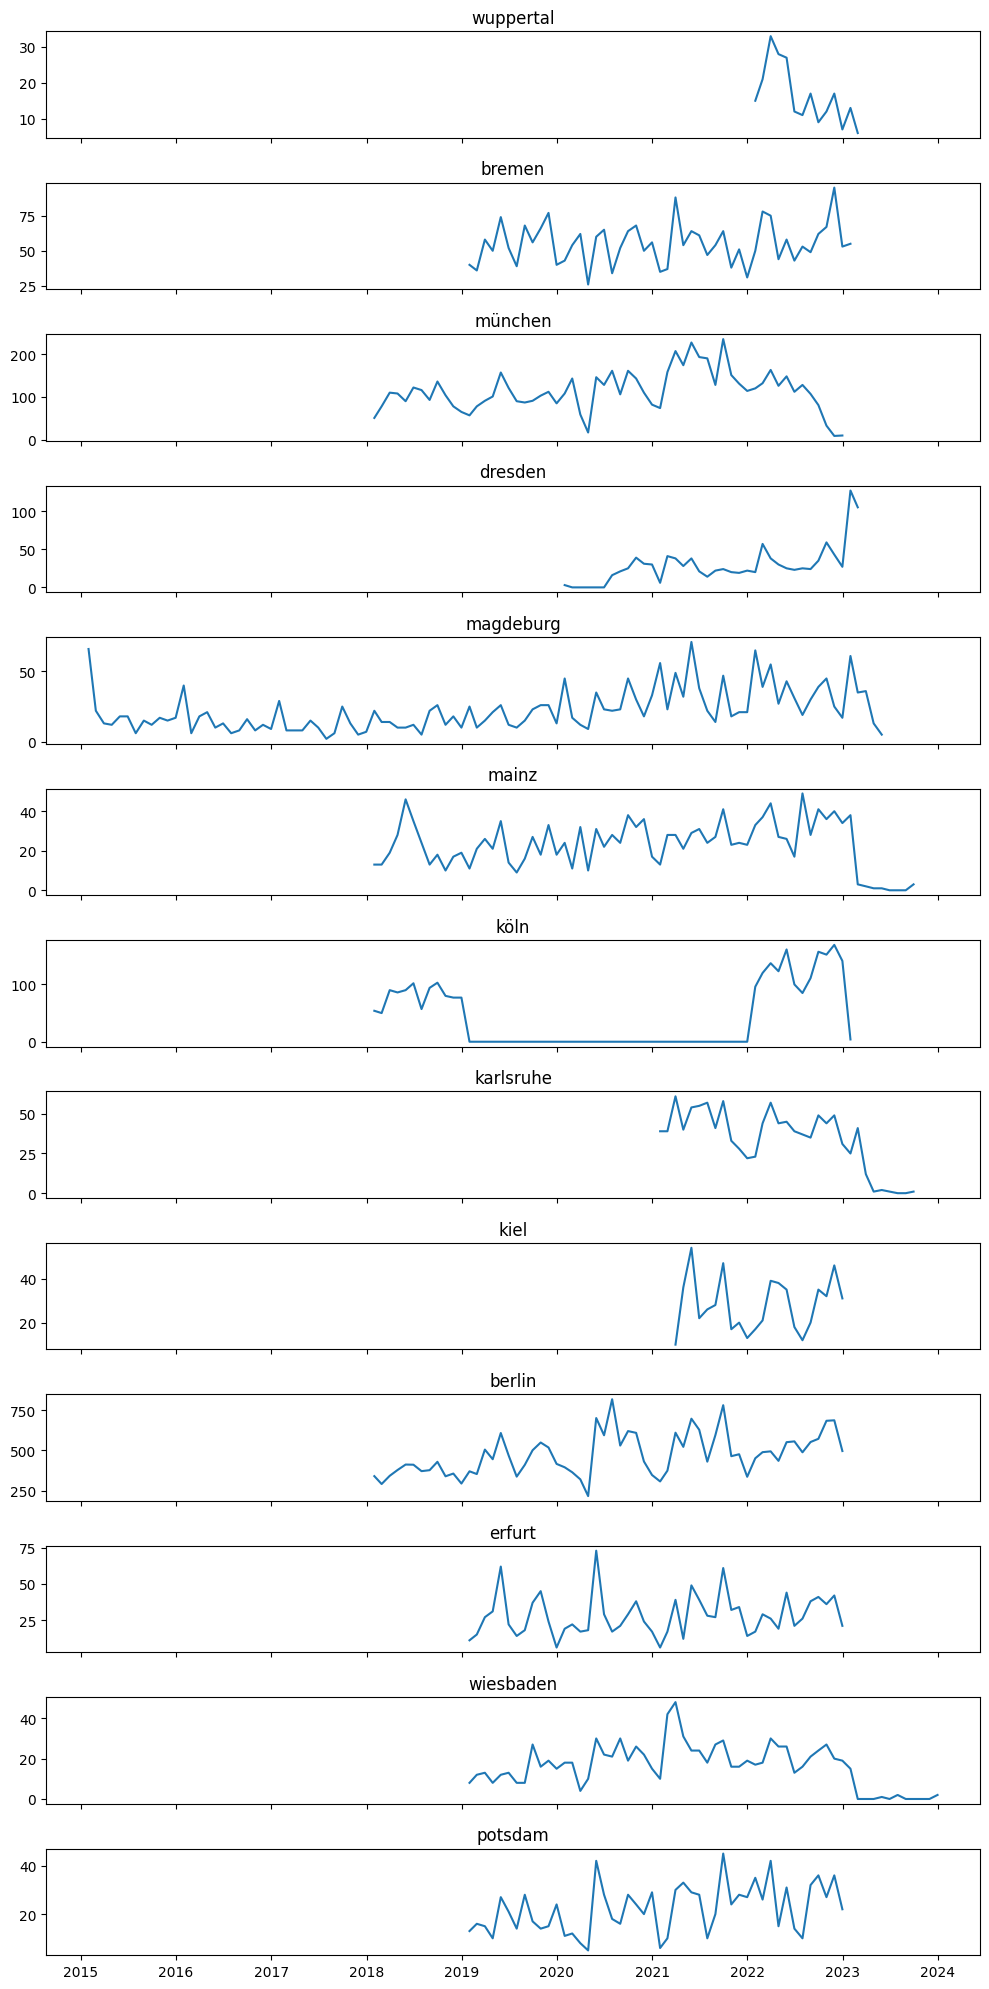

In [14]:
import matplotlib.pyplot as plt

dfs_ = dict()
fig, ax = plt.subplots(len(dfs), 1, figsize=(10, 20), sharex=True, sharey=False)
for i, (city, df_) in enumerate(dfs.items()):
    try:
        df = df_.copy()
        df.Datum = df.Datum.apply(lambda x: str(x).replace(" 00:00:00", ""))
        df = split_dates(df)
        df.Datum = pd.to_datetime(df.Datum, dayfirst=True)
        dfs_[city] = df
        n_protests = df.groupby(pd.Grouper(key="Datum", freq="M")).count()
        ax[i].plot(n_protests.Thema)
        ax[i].set_title(city)
        # print(city, df[df.Datum == df.Datum.min()])
    except Exception as e:
        print(city)
        print(e)
        pass
plt.tight_layout()
plt.show()

In [15]:
pd.concat(dfs_).columns

Index(['index', 'Anmeldung vom', 'Datum', 'Zeit', 'Versammlungsort',
       'Teilnehmer', 'Veranstalter', 'Art', 'Thema', 'Ende', 'Ort', 'Beginn',
       'Ort (ausschließlich Dresden)', 'sheet_name', 'Lfd. Nr. ',
       'Uhrzeit der Vers', 'Datum der Anmeldung', 'Teilnehmer (tatsächlich)',
       'Lfd Nr.', 'Uhrzeit', 'Anmeldedatum', 'Aufzug', 'Absage', 'Standort',
       'Kategorie', 'Stichwörter', 'Von', 'Bis', 'Strasse', 'Nr', 'PLZ',
       'Aufzugsstrecke', 'Uhrzeit der Versammlung', 'Straße'],
      dtype='object')

In [16]:
renames = [
    ("Anmeldung vom", "Anmeldedatum"),
    ("Versammlungsort", "Ort"),
    ("Ort (ausschließlich Dresden)", "Ort"),
    ("Ort(e) der Kundgebung", "Ort"),
    ("Ort/e der Kundgebung", "Ort"),
    ("Standort", "Ort"),
    ("Art", "Kategorie"),
    ("Zeit", "Uhrzeit"),
    ("Uhrzeit der Versammlung", "Uhrzeit"),
    ("Uhrzeit der Vers", "Uhrzeit"),
    ("Von", "Beginn"),
    ("Bis", "Ende"),
]
drops = [
    "sheet_name",
    "Lfd. Nr. ",
    "Lfd Nr.",
    "Strasse",
    "Straße",
    "PLZ",
    "Aufzug",
    "Aufzugsstrecke",
    "Nr",
    "index",
    "Anmeldedatum",
]

all_dfs = []
for city, df in dfs_.items():
    print(city.title())
    df["Stadt"] = city.title()
    df = df.rename(columns=dict(renames), errors="ignore")
    df = df.drop(columns=drops, errors="ignore")
    df = df.drop_duplicates().reset_index(drop=True)
    print(df.columns)
    all_dfs.append(df)
all_df = pd.concat(all_dfs, axis=0, ignore_index=True)
print(all_df.shape)
print(all_df.columns)
all_df.sample(50)

Wuppertal
Index(['Datum', 'Uhrzeit', 'Ort', 'Teilnehmer', 'Veranstalter', 'Kategorie',
       'Thema', 'Stadt'],
      dtype='object')
Bremen
Index(['Datum', 'Ende', 'Ort', 'Thema', 'Stadt'], dtype='object')
München
Index(['Datum', 'Beginn', 'Ende', 'Ort', 'Kategorie', 'Veranstalter', 'Thema',
       'Teilnehmer', 'Stadt'],
      dtype='object')
Dresden
Index(['Datum', 'Ort', 'Thema', 'Teilnehmer', 'Stadt'], dtype='object')
Magdeburg
Index(['Datum', 'Uhrzeit', 'Ort', 'Thema', 'Datum der Anmeldung', 'Teilnehmer',
       'Teilnehmer (tatsächlich)', 'Stadt'],
      dtype='object')
Mainz
Index(['Datum', 'Uhrzeit', 'Kategorie', 'Thema', 'Ort', 'Teilnehmer', 'Stadt'], dtype='object')
Köln
Index(['Datum', 'Teilnehmer', 'Thema', 'Ort', 'Stadt'], dtype='object')
Karlsruhe
Index(['Datum', 'Beginn', 'Ende', 'Thema', 'Ort', 'Teilnehmer', 'Absage',
       'Stadt'],
      dtype='object')
Kiel
Index(['Datum', 'Uhrzeit', 'Thema', 'Ort', 'Teilnehmer', 'Stadt'], dtype='object')
Berlin
Index(['Datum', 'T

,Datum,Uhrzeit,Ort,Teilnehmer,Veranstalter,Kategorie,Thema,Stadt,Ende,Beginn,Datum der Anmeldung,Teilnehmer (tatsächlich),Absage,Stichwörter
35435,2021-03-12,NaN,NaN,50.0,NaN,NaN,"""Gegen Verschwörungsmythen""",Berlin,20:00,18:00,NaN,50.0,NaN,NaN
44198,2022-07-30,NaN,NaN,150.0,NaN,NaN,"""Stand with Ukraine""",Berlin,17:30,14:30,NaN,750.0,NaN,NaN
36990,2021-05-29,NaN,NaN,5.0,NaN,NaN,"""Keine Rendite mit der Miete: Deutsche Wohnen ...",Berlin,16:30,12:30,NaN,3.0,NaN,NaN
16510,2022-10-01,NaN,Ebertplatz,200,NaN,NaN,Freiheit für Iran,Köln,NaN,NaN,NaN,NaN,NaN,NaN
42608,2022-04-30,NaN,NaN,5.0,NaN,NaN,"""Wiederaufbau des Palasts der Republik""",Berlin,20:00,13:00,NaN,1.0,NaN,NaN
44484,2022-08-15,NaN,NaN,80.0,NaN,NaN,"""Montagsspaziergang für Frieden, Freiheit, Dem...",Berlin,20:30,18:00,NaN,30.0,NaN,NaN
28528,2019-12-18,NaN,NaN,20.0,NaN,Umwelt,Meditation for future (vom 09.10. bis 25.12.20...,Berlin,NaN,NaN,NaN,4.0,NaN,NaN
4025,2022-07-23,NaN,Sendlinger Str. 8,10,Active Love,stationär,Active Love,München,18.00,15.00,NaN,NaN,NaN,NaN
16717,2022-11-30,NaN,Albertus-Magnus-Platz,40,NaN,NaN,Campus Rally for Iran - Solidarität mit den Pr...,Köln,NaN,NaN,NaN,NaN,NaN,NaN
31167,2020-06-28,NaN,NaN,20.0,NaN,Gedenken,Gedenktag an den Aufstand vom 30.06.2013,Berlin,NaN,NaN,NaN,25.0,NaN,NaN


In [17]:
all_df.shape

(50611, 14)

In [18]:
print(all_df.value_counts("Absage"))
all_df = all_df[all_df["Absage"] != "x"]
all_df = all_df.drop(columns="Absage")
all_df.shape

Absage
x    76
dtype: int64


(50535, 13)

In [19]:
# find rows where "abgesagt" is in any column
def cancelled(x):
    words = ["absage", "abgesagt", "cancelled", "canceled"]
    return any([word in str(x).lower() for word in words])


all_df = all_df[~all_df.apply(cancelled, axis=1)]
all_df.shape

(50429, 13)

In [20]:
all_df["Stadt"].value_counts()

Berlin       28234
München       6831
Bremen        2684
Köln          2602
Magdeburg     2223
Mainz         1580
Erfurt        1273
Dresden       1088
Potsdam       1065
Karlsruhe     1032
Wiesbaden      975
Kiel           613
Wuppertal      229
Name: Stadt, dtype: int64

In [22]:
from protest_impact.data.protests.acled import parse_number_string

size = all_df.query("Teilnehmer.notna()")
size_ = size["Teilnehmer"]


def is_number(x):
    try:
        int(x)
        return True
    except:
        return False


def is_numberable(x):
    size = parse_number_string(str(x))
    if size is None:
        return False
    return True


print(size[~size_.apply(is_number)].shape)
print(size[~size_.apply(is_numberable)].shape)
print(size_[~size_.apply(is_numberable)].sample(50))

(4135, 13)
(369, 13)
48669                 --
5597          noch offen
15542               k.A.
48740                 --
9323           wechselnd
48637                 --
48759                 --
48782                 --
48592                 --
48581                 --
8684           wechselnd
9202           wechselnd
48767                 --
9377           wechselnd
48694                 --
8937           wechselnd
48673                 --
14052                  #
8968           wechselnd
48630                 --
9775           unbekannt
9333           wechselnd
9331           wechselnd
48636                 --
48675                 --
48815                 --
18417                  ?
9185           wechselnd
48678                 --
15212               k.A.
48691                 --
9298           wechselnd
10430               n.b.
8687           wechselnd
48765                 --
48582                 --
48602                 --
48734                 --
10437               n.b.
4872

In [23]:
all_df["Teilnehmer"] = all_df["Teilnehmer"].apply(parse_number_string)
all_df["Teilnehmer (tatsächlich)"] = all_df["Teilnehmer (tatsächlich)"].apply(
    parse_number_string
)

In [24]:
all_df["Stadt"].unique()

array(['Wuppertal', 'Bremen', 'München', 'Dresden', 'Magdeburg', 'Mainz',
       'Köln', 'Karlsruhe', 'Kiel', 'Berlin', 'Erfurt', 'Wiesbaden',
       'Potsdam'], dtype=object)

In [25]:
regions = dict(
    Wuppertal="Nordrhein-Westfalen",
    Bremen="Bremen",
    München="Bayern",
    Dresden="Sachsen",
    Magdeburg="Sachsen-Anhalt",
    Mainz="Rheinland-Pfalz",
    Köln="Nordrhein-Westfalen",
    Karlsruhe="Baden-Württemberg",
    Kiel="Schleswig-Holstein",
    Berlin="Berlin",
    Erfurt="Thüringen",
    Wiesbaden="Hessen",
    Potsdam="Brandenburg",
)
all_df["Bundesland"] = all_df["Stadt"].apply(lambda x: regions[x])

In [26]:
all_df.sample(50)

,Datum,Uhrzeit,Ort,Teilnehmer,Veranstalter,Kategorie,Thema,Stadt,Ende,Beginn,Datum der Anmeldung,Teilnehmer (tatsächlich),Stichwörter,Bundesland
31025,2020-06-20,NaN,NaN,1000.0,NaN,Stadtpolitik,Echte Hilfe für Studierende jetzt,Berlin,NaN,NaN,NaN,300.0,Bildung,Berlin
17957,2022-05-15,NaN,"Beginn, Ende Kronenplatz",200.0,NaN,NaN,Kidical Mass - bundesweite Kinder-Fahrrad-Demo,Karlsruhe,16:00:00,15:00:00,NaN,NaN,NaN,Baden-Württemberg
7941,2019-06-06,NaN,Kölner Platz 1,15.0,ver.di München,stationär,Volksbegehren Stoppt den Pflegenotstand an Bay...,München,11.45,11.00,NaN,NaN,NaN,Bayern
19421,2018-02-12,NaN,NaN,100.0,NaN,Arbeit und Sozialpolitik,United Killers of Benetton,Berlin,NaN,NaN,NaN,20.0,NaN,Berlin
34336,2020-12-10,NaN,NaN,200.0,NaN,NaN,"""Bauernrechte in Indien""",Berlin,13:00,11:00,NaN,380.0,NaN,Berlin
26460,2019-08-14,NaN,NaN,20.0,NaN,Frieden,Schluss mit der aggressiven Politik der NATO.....,Berlin,NaN,NaN,NaN,0.0,NaN,Berlin
138,2022-06-22,18:00 - 20:30,Döppersberg,100.0,NaN,Aufzug,für Grundrechte und Selbstbestimmung,Wuppertal,NaN,NaN,NaN,NaN,NaN,Nordrhein-Westfalen
46535,2022-11-23,NaN,NaN,10.0,NaN,NaN,"""Menschenrechtsverletzungen der Psychiatrie"" (...",Berlin,20:00,08:00,NaN,NaN,NaN,Berlin
25993,2019-07-03,NaN,NaN,50.0,NaN,rechts,Merkel muss weg Mittwoch (vom 09.01. bis 31.12...,Berlin,NaN,NaN,NaN,28.0,NaN,Berlin
4104,2021-01-16,NaN,Brucknerstr. Zwischen Prinzregenten- und Zaubz...,135.0,Isarlust e.V.,stationär,Kulturlieferdienst,München,16:30:00,15:30:00,NaN,NaN,NaN,Bayern


In [28]:
all_df.to_csv(
    project_root
    / "protest_impact/data/protests/german_protest_registrations"
    / "all-protests.csv",
    index=False,
)

[]

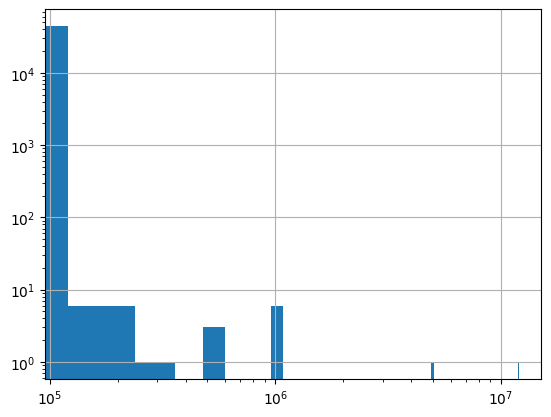

In [29]:
all_df["Teilnehmer"].hist(bins=100)
plt.loglog()